In [30]:
%matplotlib widget
import os
import numpy as np
import matplotlib.pyplot as plt
import importlib
from matplotlib import cycler
import torch
from torch import nn

try:
    importlib.reload(dd)
except NameError:
    import disjoint_domain as dd

try:
    importlib.reload(ddnet)
except NameError:
    import ddnet
    
try:
    importlib.reload(util)
except NameError:
    import util


simple_net_params = {
    'n_domains': 3, 'use_ctx_repr': False, 'use_ctx': False,
    'attrs_per_context': 200, 'hidden_units': 48, 'ctx_per_domain': 1,
    'fix_biases': True, 'fixed_bias': 0
}

simple_train_params = {
    'reports_per_test': np.inf, 'holdout_testing': 'domain',
    'test_thresh': 0.85, 'num_epochs': 15000
}

In [20]:
path_orig = ddnet.train_n_nets(n=100, run_type='final_runs/sigmoid_2hl_2domain_1ctx',
                               net_params=simple_net_params, train_params=simple_train_params)[0]

path_linear = ddnet.train_n_nets(n=100, run_type='final_runs/linear_2hl_2domain_1ctx',
                                 train_params=simple_train_params,
                                 net_params={**simple_net_params, 'act_fn': nn.Identity(),
                                             'loss_fn': nn.MSELoss})[0]

Training Iteration 1
---------------------
Using CUDA
Holding out domain C
Epoch     0: loss = 415.877, weighted acc = 0.000, epochs for new domain  = 2912
Epoch    50: loss =  58.095, weighted acc = 0.434
Epoch   100: loss =  57.475, weighted acc = 0.434
Epoch   150: loss =  57.268, weighted acc = 0.434
Epoch   200: loss =  57.164, weighted acc = 0.434
Epoch   250: loss =  57.101, weighted acc = 0.434
Epoch   300: loss =  57.059, weighted acc = 0.434
Epoch   350: loss =  57.029, weighted acc = 0.434
Epoch   400: loss =  57.007, weighted acc = 0.434
Epoch   450: loss =  56.989, weighted acc = 0.434
Epoch   500: loss =  56.975, weighted acc = 0.434
Epoch   550: loss =  56.963, weighted acc = 0.434
Epoch   600: loss =  56.953, weighted acc = 0.434
Epoch   650: loss =  56.945, weighted acc = 0.434
Epoch   700: loss =  56.938, weighted acc = 0.434
Epoch   750: loss =  56.931, weighted acc = 0.434
Epoch   800: loss =  56.926, weighted acc = 0.434
Epoch   850: loss =  56.921, weighted acc = 

('data/final_runs/linear_2hl_2domain_1ctx_dd_res_2021-12-19_14-35-00.npz',
 DisjointDomainNet(
   (act_fn): Identity()
   (output_act_fn): Identity()
   (criterion): MSELoss()
   (item_to_rep): Linear(in_features=24, out_features=16, bias=False)
   (rep_to_hidden): Linear(in_features=19, out_features=48, bias=False)
   (hidden_to_attr): Linear(in_features=48, out_features=600, bias=False)
 ))

In [23]:
# Try version where loss is only computed on same domain for each item
path_no_cd_loss = ddnet.train_n_nets(n=100, run_type='final_runs/no_crossdomain_loss_sigmoid',
                                     net_params={**simple_net_params, 'include_cross_domain_loss': False},
                                     train_params=simple_train_params)[0]

Training Iteration 1
---------------------
Using CUDA
Holding out domain C
Epoch     0: loss = 138.515, weighted acc = 0.000, epochs for new domain  = 1949
Epoch    50: loss =  35.082, weighted acc = 0.269
Epoch   100: loss =  34.650, weighted acc = 0.269
Epoch   150: loss =  34.511, weighted acc = 0.269
Epoch   200: loss =  34.442, weighted acc = 0.269
Epoch   250: loss =  34.399, weighted acc = 0.269
Epoch   300: loss =  34.370, weighted acc = 0.269
Epoch   350: loss =  34.348, weighted acc = 0.269
Epoch   400: loss =  34.331, weighted acc = 0.269
Epoch   450: loss =  34.316, weighted acc = 0.269
Epoch   500: loss =  34.304, weighted acc = 0.269
Epoch   550: loss =  34.293, weighted acc = 0.269
Epoch   600: loss =  34.283, weighted acc = 0.269
Epoch   650: loss =  34.274, weighted acc = 0.269
Epoch   700: loss =  34.264, weighted acc = 0.269
Epoch   750: loss =  34.255, weighted acc = 0.269
Epoch   800: loss =  34.246, weighted acc = 0.269
Epoch   850: loss =  34.235, weighted acc = 

In [27]:
# Also train each network type on ring-ring
tree_cluster_info = '4-2-2'
ring_cluster_info = {'clusters': '8', 'intragroup_dists': [12], 'rotating_overlap': 18}
ring_net_params = {**simple_net_params, 'cluster_info': ring_cluster_info}

path_ring_sigmoid = ddnet.train_n_nets(n=100, run_type='final_runs/ring_sigmoid_2hl_2domain_1ctx',
                                       net_params=ring_net_params, train_params=simple_train_params)[0]

path_ring_linear = ddnet.train_n_nets(n=100, run_type='final_runs/ring_linear_2hl_2domain_1ctx',
                                      train_params=simple_train_params,
                                      net_params={**ring_net_params, 'act_fn': nn.Identity(),
                                                  'loss_fn': nn.MSELoss})[0]

path_ring_no_cd_loss = ddnet.train_n_nets(n=100, run_type='final_runs/ring_no_crossdomain_loss_sigmoid',
                                          net_params={**ring_net_params, 'include_cross_domain_loss': False},
                                          train_params=simple_train_params)[0]

In [29]:
# Reload runs and do domain holdout testing, every 200 epochs up to 6000 epochs.

def make_different_last_domain_restorer(last_domain_cluster_info):
    def restore_nets_with_different_last_domain(res_path, epochs):
        def replace_last_domain(single_net_restorer):
            net, train_params = next(single_net_restorer)
            y = net.y
            net.last_domain_cluster_info = last_domain_cluster_info
            new_y = net.gen_training_tensors()[2]
            x_per_domain = y.shape[0] // net.n_domains
            y[-x_per_domain:] = new_y[-x_per_domain:]
            net.y = y
            yield net, train_params
            
            for net, train_params in single_net_restorer:
                net.y = y
                yield net, train_params
            return
            
        return (replace_last_domain(single_net_restorer)
                for single_net_restorer in ddnet.restore_each_net_over_epochs(res_path, epochs))

    return restore_nets_with_different_last_domain

test_paths_tree = [path_orig, path_linear, path_no_cd_loss]
test_paths_ring = [path_ring_sigmoid, path_ring_linear, path_ring_no_cd_loss]
epochs = np.arange(0, 6001, 200)

for res_path in test_paths_tree:
    path_base = os.path.splitext(res_path)[0]
    ddnet.restore_and_holdout_test(res_path, epochs, path_base + 'domainho_ring.npz',
                                   make_different_last_domain_restorer(ring_cluster_info))
    ddnet.restore_and_holdout_test(res_path, epochs, path_base + 'domainho_tree.npz')
    
for res_path in test_paths_ring:
    path_base = os.path.splitext(res_path)[0]
    ddnet.restore_and_holdout_test(res_path, epochs, path_base + 'domainho_ring.npz')
    ddnet.restore_and_holdout_test(res_path, epochs, path_base + 'domainho_tree.npz',
                                   make_different_last_domain_restorer(tree_cluster_info))

Network 0 testing start
-------------------------
Epoch 0: 3744 epochs to generalize
Epoch 200: 3560 epochs to generalize
Epoch 400: 3203 epochs to generalize
Epoch 600: 3811 epochs to generalize
Epoch 800: 3036 epochs to generalize
Epoch 1000: 3064 epochs to generalize
Epoch 1200: 2851 epochs to generalize
Epoch 1400: 3129 epochs to generalize
Epoch 1600: 2845 epochs to generalize
Epoch 1800: 2716 epochs to generalize
Epoch 2000: 3009 epochs to generalize
Epoch 2200: 2663 epochs to generalize
Epoch 2400: 2878 epochs to generalize
Epoch 2600: 2526 epochs to generalize
Epoch 2800: 2705 epochs to generalize
Epoch 3000: 2276 epochs to generalize
Epoch 3200: 2505 epochs to generalize
Epoch 3400: 2123 epochs to generalize
Epoch 3600: 1885 epochs to generalize
Epoch 3800: 2114 epochs to generalize
Epoch 4000: 2230 epochs to generalize
Epoch 4200: 2086 epochs to generalize
Epoch 4400: 2304 epochs to generalize
Epoch 4600: 2204 epochs to generalize
Epoch 4800: 2034 epochs to generalize
Epoch 5

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
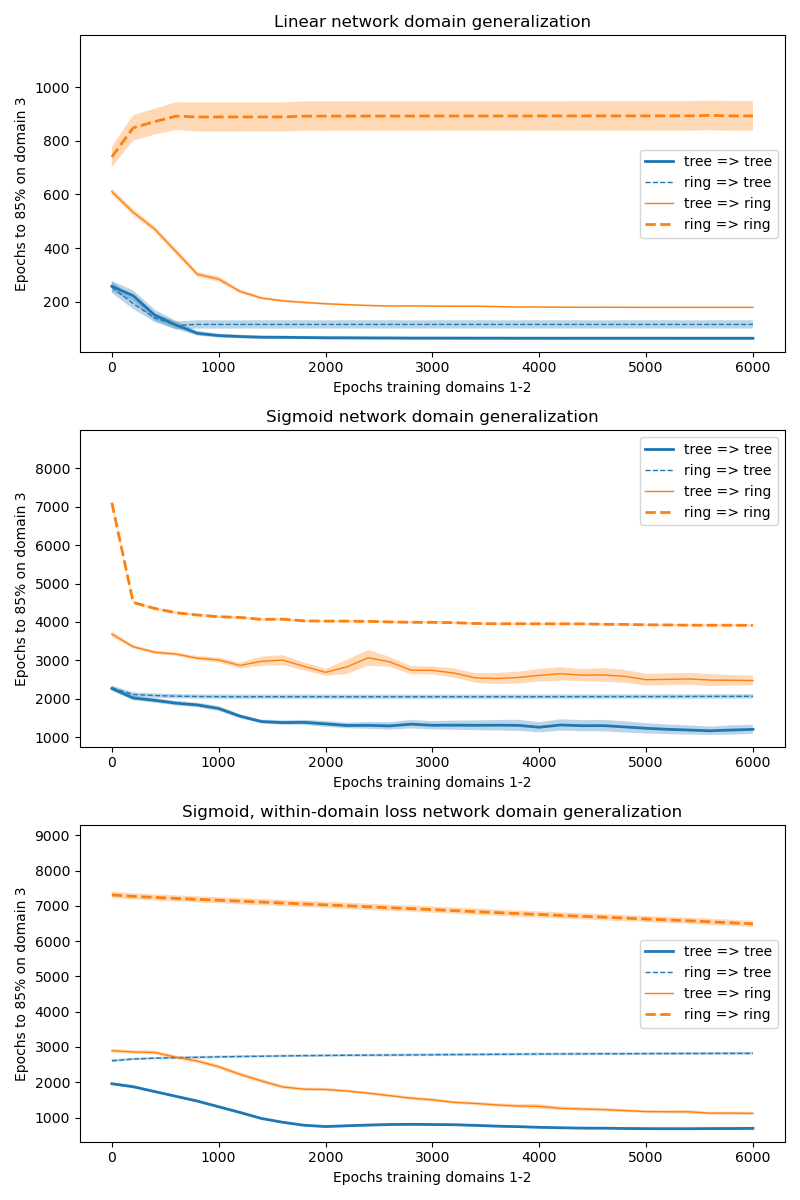

In [38]:
# Plot domain holdout results

domain_holdout_paths = {
    'Linear': {
        'tree => tree': 'data/final_runs/linear_2hl_2domain_1ctx_dd_res_2021-12-19_14-35-00domainho_tree.npz',
        'ring => tree': 'data/final_runs/ring_linear_2hl_2domain_1ctx_dd_res_2021-12-27_16-32-01domainho_tree.npz',
        'tree => ring': 'data/final_runs/linear_2hl_2domain_1ctx_dd_res_2021-12-19_14-35-00domainho_ring.npz',
        'ring => ring': 'data/final_runs/ring_linear_2hl_2domain_1ctx_dd_res_2021-12-27_16-32-01domainho_ring.npz',
    },
    'Sigmoid': {
        'tree => tree': 'data/final_runs/sigmoid_2hl_2domain_1ctx_dd_res_2021-12-19_13-58-48domainho_tree.npz',
        'ring => tree': 'data/final_runs/ring_sigmoid_2hl_2domain_1ctx_dd_res_2021-12-27_15-44-22domainho_tree.npz',
        'tree => ring': 'data/final_runs/sigmoid_2hl_2domain_1ctx_dd_res_2021-12-19_13-58-48domainho_ring.npz',
        'ring => ring': 'data/final_runs/ring_sigmoid_2hl_2domain_1ctx_dd_res_2021-12-27_15-44-22domainho_ring.npz',
    },
    'Sigmoid, within-domain loss': {
        'tree => tree': 'data/final_runs/no_crossdomain_loss_sigmoid_dd_res_2021-12-27_13-41-47domainho_tree.npz',
        'ring => tree': 'data/final_runs/ring_no_crossdomain_loss_sigmoid_dd_res_2021-12-27_18-31-54domainho_tree.npz',
        'tree => ring': 'data/final_runs/no_crossdomain_loss_sigmoid_dd_res_2021-12-27_13-41-47domainho_ring.npz',
        'ring => ring': 'data/final_runs/ring_no_crossdomain_loss_sigmoid_dd_res_2021-12-27_18-31-54domainho_ring.npz',
    }
}

# Set color/line style cycle to highlight runs expected to have lower ETG
col_cycle = plt.rcParams['axes.prop_cycle'][:2]
line_cycle = cycler(linestyle=['-', '--'])
weight_cycle = cycler(lw=[2, 1, 1, 2])
prop_cycle = col_cycle * line_cycle + weight_cycle

n_types = len(domain_holdout_paths)
fig, axs = util.auto_subplots(n_types, 1, ax_dims=(8, 4), prop_cycle=prop_cycle)

for (label, paths), ax in zip(domain_holdout_paths.items(), axs.ravel()):
    ax.set_title(f'{label} network domain generalization')
    for direction_label, path in paths.items():
        with np.load(path) as dho_file:
            mean_etg, ci_etg = util.get_mean_and_ci(dho_file['etg'])
            etg_epochs = dho_file['test_epochs']

        ax.plot(etg_epochs, mean_etg, label=direction_label)
        ax.fill_between(etg_epochs, *ci_etg, alpha=0.3)
    
    ax.legend()
    ax.set_xlabel('Epochs training domains 1-2')
    ax.set_ylabel(f'Epochs to {simple_train_params["test_thresh"] * 100:g}% ' +
                  'on domain 3')
    
    curr_ylims = ax.get_ylim()
    ax.set_ylim((curr_ylims[0], curr_ylims[1] * 1.2))

fig.tight_layout()
plt.show()

util.print_svg(fig, 'figures/dd_domain_holdout.svg')